In [104]:
import numpy as np
import matplotlib.pyplot as pyplot
from scipy import optimize
from scipy.io import loadmat
import csv
import pandas as pd

In [86]:
# Configurando parametros necesario
input_layer_size = 3072     # Entrada de imagenes de digitos de 32x32, 3 canales de color
hidden_layer_size1 = 40      # 35 neuronas ocultas primer capa
hidden_layer_size2 = 25     # 35 neuronas ocultas segunda capa
num_labels = 10             # 10 etiquetas, de 0 a 9

# https://www.cs.toronto.edu/~kriz/cifar.html
data_train1 = loadmat('data_batch_1.mat')
data_train2 = loadmat('data_batch_2.mat')
data_train3 = loadmat('data_batch_3.mat')
data_train4 = loadmat('data_batch_4.mat')
data_train5 = loadmat('data_batch_5.mat')

# mostramos un ejempos para saber como es la estructura de los datos de los datasets
print('Dataset data_batch_1.mat => ',data_train1.keys())
data_test = loadmat('test_batch.mat')
print('Dataset de test => ',data_test.keys())

Dataset data_batch_1.mat =>  dict_keys(['__header__', '__version__', '__globals__', 'data', 'labels', 'batch_label'])
Dataset de test =>  dict_keys(['__header__', '__version__', '__globals__', 'data', 'labels', 'batch_label'])


In [87]:
print('-------Datos de entrenamiento-------')
X_train = data_train = np.concatenate((data_train1['data'], data_train2['data'], data_train3['data'], data_train4['data'], data_train5['data']), axis=0)
print('X shape: ',X_train.shape)
y_train = data_train = np.concatenate((data_train1['labels'], data_train2['labels'], data_train3['labels'], data_train4['labels'], data_train5['labels']), axis=0).ravel()
y_train[y_train == 10] = 0
print('y shape: ',y_train.shape)
print('y clases: ',set(y_train))
print('-------Datos de test-------')
X_test = data_test['data']
print('X shape: ',X_test.shape)
y_test = data_test['labels'].ravel()
y_test[y_test == 10] = 0
print('y shape: ',y_test.shape)
print('y clases: ',set(y_test))

-------Datos de entrenamiento-------
X shape:  (50000, 3072)
y shape:  (50000,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
-------Datos de test-------
X shape:  (10000, 3072)
y shape:  (10000,)
y clases:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [88]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n / 3)))
    example_height = int(n / (example_width * 3))

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        img = X[i].reshape(example_height, example_width, 3, order='F')
        ax.imshow(img)
        ax.axis('off')

    pyplot.show()


In [89]:
# funcion para normalizar las caracteristicas
def featureNormalize(X):
    X_norm = X.copy()
    media_norm = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)

    # Ignorar las advertencias de división por cero
    with np.errstate(divide='ignore', invalid='ignore'):
        X_norm = (X - media_norm) / sigma

    # Reemplazar los valores NaN o infinitos con cero
    X_norm = np.nan_to_num(X_norm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

    return X_norm, media_norm, sigma

In [90]:
# normalizamos las X's de entrenamiento
X_train_norm, train_media_norm, train_sigma = featureNormalize(X_train)
# normalizamos las X's de prueba
X_test_norm, test_media_norm, test_sigma = featureNormalize(X_test)

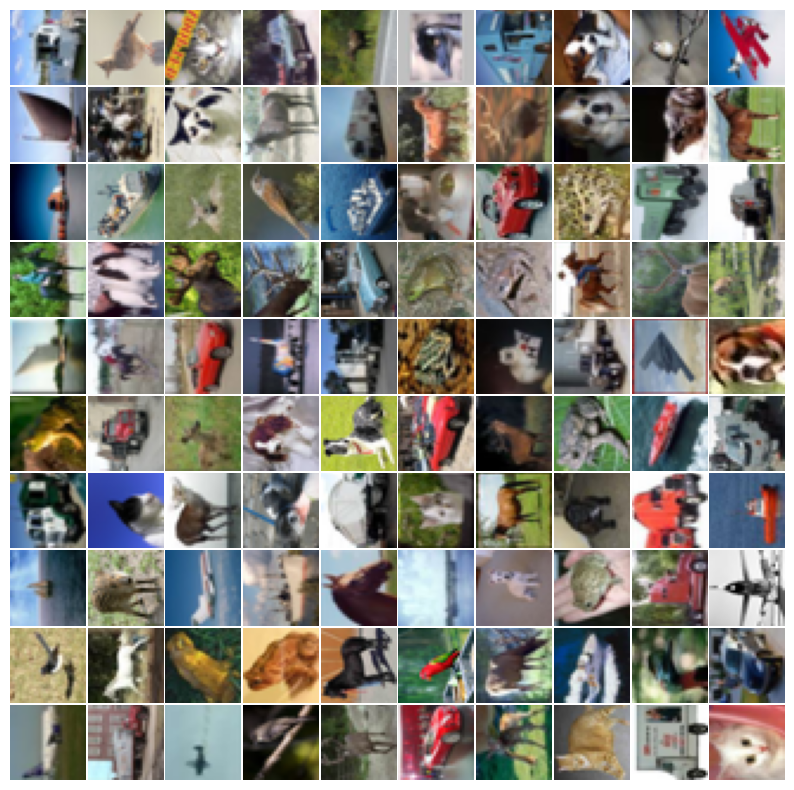

In [91]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
m = y_train.size
rand_indices = np.random.choice(m, 100, replace=False)
sel = X_train[rand_indices, :]

displayData(sel)

In [92]:
def checkNNGradients(nnCostFunction, lambda_=0.0):
    """
    Verifica los gradientes calculados por backpropagation en una red neuronal.

    Parameters:
    - nnCostFunction: Función de costo de la red neuronal.
    - lambda_: Parámetro de regularización (por defecto es 0.0).

    Returns:
    - diff: Diferencia relativa entre los gradientes numéricos y los gradientes aproximados por backpropagation.
    """

    # Obtén los gradientes por backpropagation
    cost, grad = nnCostFunction()

    # Inicializa los gradientes numéricos
    numgrad = np.zeros_like(grad)

    # Valor pequeño para la aproximación numérica
    epsilon = 1e-4

    # Itera sobre cada parámetro en la red neuronal
    for i in range(len(grad)):
        # Aproximación numérica del gradiente
        theta_plus = np.copy(nnCostFunction.theta)
        theta_plus[i] += epsilon
        theta_minus = np.copy(nnCostFunction.theta)
        theta_minus[i] -= epsilon

        # Cálculo del costo para los parámetros theta_plus y theta_minus
        cost_plus, _ = nnCostFunction(theta_plus, lambda_)
        cost_minus, _ = nnCostFunction(theta_minus, lambda_)

        # Aproximación numérica del gradiente
        numgrad[i] = (cost_plus - cost_minus) / (2 * epsilon)

    # Calcula la diferencia relativa entre los gradientes numéricos y los gradientes por backpropagation
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)

    return diff

def sigmoid(z):
    """
    Calcula la función sigmoide de un número o una matriz.

    Parameters:
    - z: Número o matriz.

    Returns:
    - result: Resultado de aplicar la función sigmoide a z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [93]:
def sigmoidGradient(z):
    """
    Calcula el gradiente de la función sigmoidea evaluada en z.
    Esto debería funcionar independientemente de si z es una matriz o un vector. 
    En particular, si z es un vector o una matriz, debe devolver el gradiente para cada elemento.
    
    Nota
    Hemos proporcionado una implementación de la función sigmoidea
    en el archivo `utils.py` que acompaña a esta tarea.
    """

    g = np.zeros(z.shape)

    g = sigmoid(z) * (1 - sigmoid(z))

    return g

In [94]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size1, hidden_layer_size2, num_labels, X, y, lambda_=0.0):
    m = y.size

    # Reformar nn_params en matrices de peso Theta1, Theta2 y Theta3
    Theta1 = nn_params[:hidden_layer_size1 * (input_layer_size + 1)].reshape(hidden_layer_size1, (input_layer_size + 1))
    start = hidden_layer_size1 * (input_layer_size + 1)
    Theta2 = nn_params[start:start + hidden_layer_size2 * (hidden_layer_size1 + 1)].reshape(hidden_layer_size2, (hidden_layer_size1 + 1))
    start += hidden_layer_size2 * (hidden_layer_size1 + 1)
    Theta3 = nn_params[start:].reshape(num_labels, (hidden_layer_size2 + 1))

    # retroalimentación (Feedforward)
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)
    a3 = np.concatenate([np.ones((m, 1)), a3], axis=1)
    z4 = a3 @ Theta3.T
    a4 = sigmoid(z4)

    # Calcular costo
    y_matrix = np.eye(num_labels)[y.reshape(-1)]
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])) + np.sum(np.square(Theta3[:, 1:])))
    J = (-1 / m) * np.sum((np.log(a4) * y_matrix) + np.log(1 - a4) * (1 - y_matrix)) + reg_term

    # Retropropagación (Backpropagation)
    delta_4 = a4 - y_matrix
    delta_3 = delta_4 @ Theta3[:, 1:] * sigmoidGradient(z3)
    delta_2 = delta_3 @ Theta2[:, 1:] * sigmoidGradient(z2)

    Delta1 = delta_2.T @ a1
    Delta2 = delta_3.T @ a2
    Delta3 = delta_4.T @ a3

    # Calcular gradientes
    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]
    Theta3_grad = (1 / m) * Delta3
    Theta3_grad[:, 1:] += (lambda_ / m) * Theta3[:, 1:]

    # Concatenar degradados en una sola matriz
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel(), Theta3_grad.ravel()])

    return J, grad


In [95]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Inicializar aleatoriamente los pesos de una capa en una red neuronal.
    
     Parámetros
     ----------
     L_in : int
         Número de conexiones entrantes.
    
     L_out: int
         Número de conexiones salientes.
    
     epsilon_init: flotante, opcional
         Rango de valores que puede tomar el peso de un uniforme
         distribución.
    
     Devoluciones
     -------
     W : array_like
         El peso inicializado a valores aleatorios. Tenga en cuenta que W debe
         establecerse en una matriz de tamaño (L_out, 1 + L_in) como
         la primera columna de W maneja los términos de "sesgo".
    """
        

    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [96]:
print('Inicialización de parámetros de redes neuronales...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size1)
initial_Theta2 = randInitializeWeights(hidden_layer_size1, hidden_layer_size2)
initial_Theta3 = randInitializeWeights(hidden_layer_size2, num_labels)

print('initial_Theta1 shape: ',initial_Theta1.shape)
print('initial_Theta2 shape: ',initial_Theta2.shape)
print('initial_Theta3 shape: ',initial_Theta3.shape)

# Desenrrollar parametros
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel(), initial_Theta3.ravel()], axis=0)

Inicialización de parámetros de redes neuronales...
initial_Theta1 shape:  (40, 3073)
initial_Theta2 shape:  (25, 41)
initial_Theta3 shape:  (10, 26)


In [97]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [100]:
# Una vez que haya completado la tarea, cambie el maxiter a un valor mayor para ver cómo ayuda más entrenamiento.
options = {'maxfun': 1000}

# También deberías probar diferentes valores de lambda
lambda_ = 1

# Cree una "mano abreviada" para que la función de costo se minimice
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size1, hidden_layer_size2,
                                        num_labels, X_train_norm, y_train, lambda_)

# Ahora, costFunction es una función que toma solo un argumento
# (los parámetros de la red neuronal)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# Obtener la solución de la optimización.
nn_params = res.x
        
# Obtener Theta1, Theta2 y Theta3 de nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size1 * (input_layer_size + 1)],
                    (hidden_layer_size1, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size1 * (input_layer_size + 1)): 
                              (hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1))],
                    (hidden_layer_size2, (hidden_layer_size1 + 1)))

Theta3 = np.reshape(nn_params[(hidden_layer_size1 * (input_layer_size + 1)) + (hidden_layer_size2 * (hidden_layer_size1 + 1)):],
                    (num_labels, (hidden_layer_size2 + 1)))


In [101]:
print('Theta1 shape: ',Theta1.shape)
print('Theta2 shape: ',Theta2.shape)
print('Theta3 shape: ',Theta3.shape)

Theta1 shape:  (40, 3073)
Theta2 shape:  (25, 41)
Theta3 shape:  (10, 26)


In [102]:
# funcion para crear archivos csv
def escribir_thetas_a_csv(matriz, nombre_archivo):
    with open(nombre_archivo, mode='w', newline='') as archivo_csv:
        writer = csv.writer(archivo_csv, delimiter=',')
        for fila in matriz:
            writer.writerow(fila)

In [106]:
escribir_thetas_a_csv(Theta1, 'Theta1.csv')
escribir_thetas_a_csv(Theta2, 'Theta2.csv')
escribir_thetas_a_csv(Theta3, 'Theta3.csv')
Theta1_data = pd.read_csv('Theta1.csv', header=None)
# Obtiene las dimensiones del DataFrame
print(Theta1_data.shape)
Theta2_data = pd.read_csv('Theta2.csv', header=None)
# Obtiene las dimensiones del DataFrame
print(Theta2_data.shape)
Theta3_data = pd.read_csv('Theta3.csv', header=None)
# Obtiene las dimensiones del DataFrame
print(Theta3_data.shape)

(40, 3073)
(25, 41)
(10, 26)


In [107]:
def predict(Theta1, Theta2, Theta3, X):
    """
    Predict the label of an input given a trained neural network.

    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)

    Theta2: array_like
        Weights for the second layer in the neural network.
        It has shape (output layer size x 2nd hidden layer size)

    X : array_like
        The image inputs having shape (number of examples x image dimensions).

    Return
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.

    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.

    """
    # Asegurarse de que la entrada tenga dos dimensiones
    if X.ndim == 1:
        X = X.reshape(1, -1)  # reshape a dos dimensiones

    # Variables útiles
    m = X.shape[0]
    num_labels = Theta3.shape[0]

    p = np.zeros(X.shape[0])

    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

    a3 = sigmoid(a2.dot(Theta2.T))
    a3 = np.concatenate([np.ones((a3.shape[0], 1)), a3], axis=1)

    p = np.argmax(sigmoid(a3.dot(Theta3.T)), axis=1)

    return p

In [108]:
train_pred = predict(Theta1, Theta2, Theta3, X_train_norm)
print('Precisión del conjunto de entrenamiento: {:.1f}%'.format(np.mean(train_pred == y_train) * 100))
test_pred = predict(Theta1, Theta2, Theta3, X_test_norm)
print('Precisión del conjunto de test: {:.1f}%'.format(np.mean(test_pred == y_test) * 100))

Precisión del conjunto de entrenamiento: 65.3%
Precisión del conjunto de test: 39.5%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

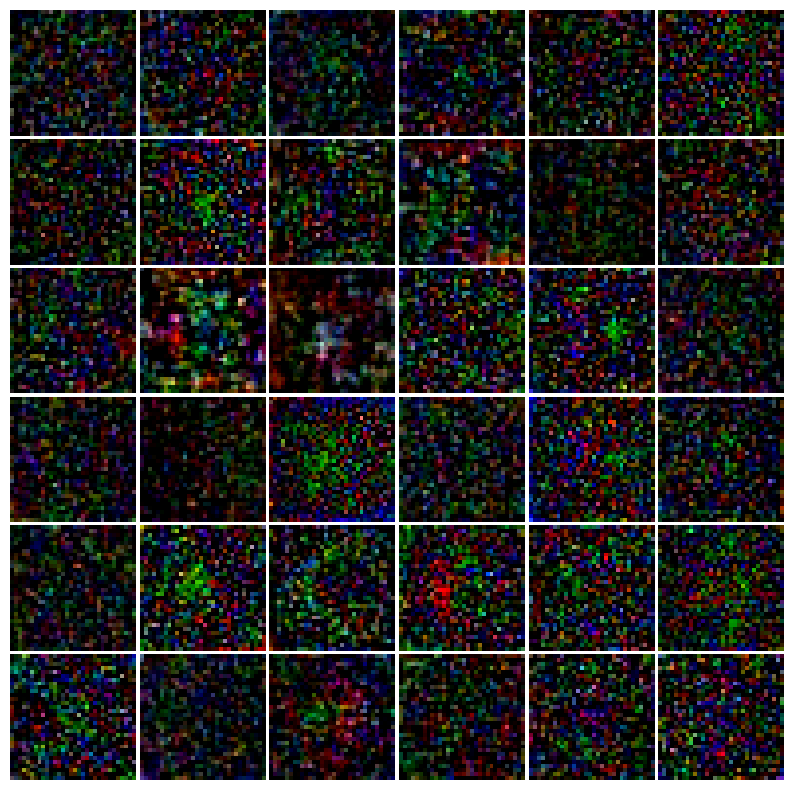

In [118]:
displayData(Theta1[:36, 1:])

In [119]:
def nombreClase(y):
    """
    Convierte un vector de etiquetas en un vector de nombres de clase.
    """
    # Nombres de las clases
    nombres = ['Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

    # Convierte y a una lista si no es iterable
    if not isinstance(y, (list, tuple, np.ndarray)):
        y = [y]

    # Devuelve el nombre de la clase para cada etiqueta en y
    return np.array([nombres[int(i)] for i in y])


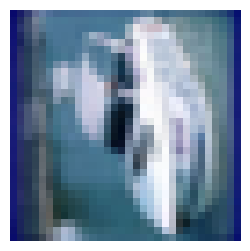

Predicción de la red neuronal: 8
Nombre de la clase: ['Barco']
------Datos reales------
Clase real:  8
Nombre de la clase: ['Barco']


In [134]:
fila_test = 6321
displayData(X_test[fila_test, :], figsize=(3, 3))
pred = predict(Theta1, Theta2, Theta3, X_test_norm[fila_test, :])
print('Predicción de la red neuronal: {}'.format(*pred))
print('Nombre de la clase: {}'.format(nombreClase(pred)))
print('------Datos reales------')
print('Clase real: ', y_test[fila_test])
print('Nombre de la clase: {}'.format(nombreClase(y_test[fila_test])))

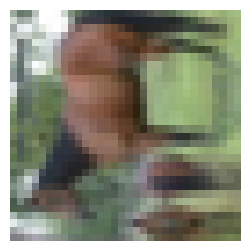

Predicción de la red neuronal: 7
Nombre de la clase: ['Caballo']
------Datos reales------
Clase real:  7
Nombre de la clase: ['Caballo']


In [135]:
displayData(X_train[fila_test, :], figsize=(3, 3))
pred = predict(Theta1, Theta2, Theta3, X_train_norm[fila_test, :])
print('Predicción de la red neuronal: {}'.format(*pred))
print('Nombre de la clase: {}'.format(nombreClase(pred)))
print('------Datos reales------')
print('Clase real: ', y_train[fila_test])
print('Nombre de la clase: {}'.format(nombreClase(y_train[fila_test])))